In [18]:
#%matplotlib widget
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import pack_vis
import pack_dimer
import pack_vis_sol
import pack_cost
import numpy as np
import cupy as cp
import copy
kgs.set_float32(True)

In [19]:
import pack_io
importlib.reload(pack_io)
import pandas as pd
theirs = pack_io.dataframe_to_solution_list(pd.read_csv(kgs.temp_dir + '71.66.csv'))

In [20]:
# from tqdm import tqdm
# import multiprocess

# multiprocess.set_start_method('spawn', force=True)

# def do_one(sol):
#     import pack_io
#     import kaggle_support as kgs
#     kgs.set_float32(True)
#     return pack_io.legalize(sol)

# with multiprocess.Pool(processes=5) as pool:
#     overall_best_legalized = list(
#         tqdm(
#             pool.imap(do_one, overall_best),
#             total=len(overall_best),
#             desc="Legalizing"
#         )
#     )
# #kgs.dill_save(kgs.temp_dir + 'tess_legalized.pickle', overall_best_legalized)
# kgs.dill_save(kgs.code_dir + '../res/tess_legalized.pickle', pop)
overall_best_legalized = kgs.dill_load(kgs.code_dir + '../res/tess_legalized.pickle')
for s in overall_best_legalized:
    s.xyt = s.xyt.astype(kgs.dtype_cp)
    s.h = s.h.astype(kgs.dtype_cp)
overall_best_legalized_score = [(x.h[0,0]**2/x.N_trees).get() for x in overall_best_legalized]
mine = (overall_best_legalized, overall_best_legalized_score)

(np.float64(71.65614508068765),
 np.float32(72.19834),
 np.float64(71.11267297433531))

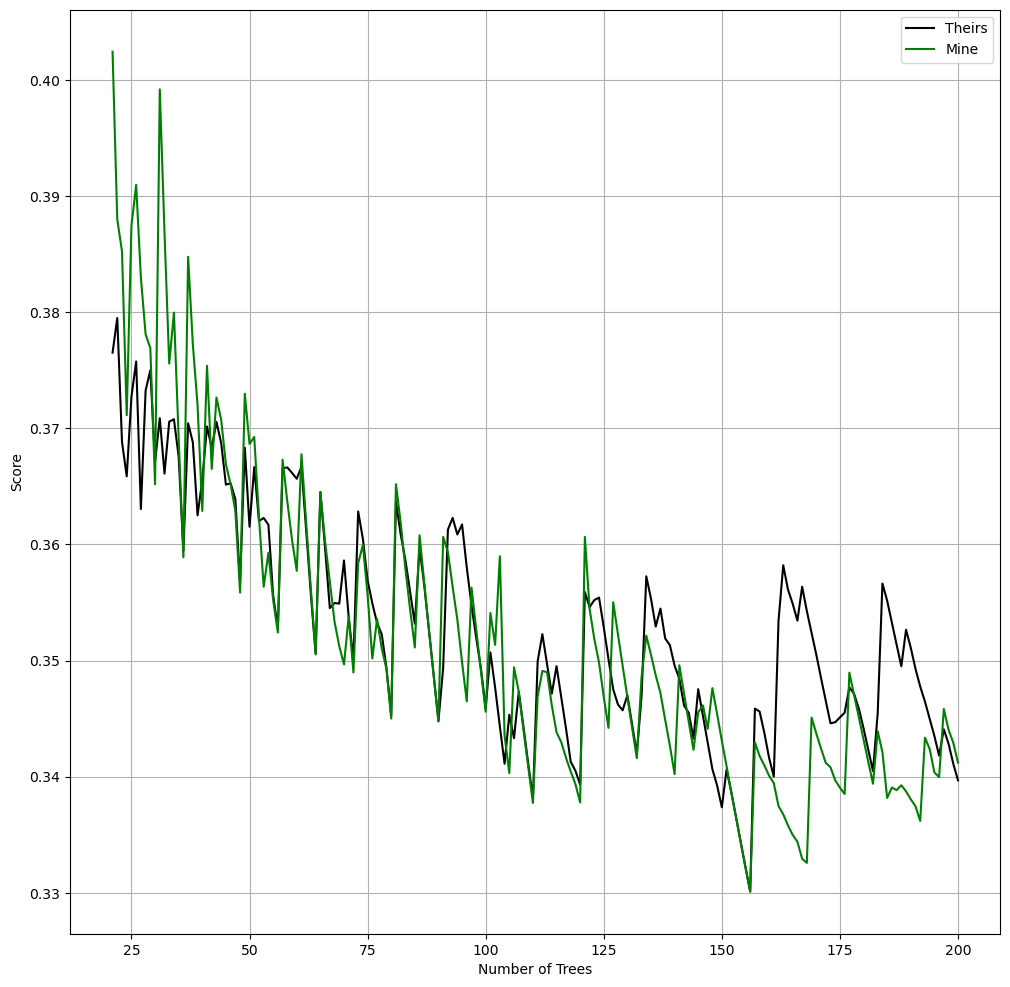

In [17]:
import mplcursors
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
N_trees = np.arange(1,201)
N=20
lines = []
vals_res = np.array([np.inf]*200)
line = plt.plot(N_trees[N:], theirs[1][N:], 'k')
lines.extend(line)
line = plt.plot(N_trees[N:], mine[1][N:], 'g')
lines.extend(line)

plt.grid(True)
plt.legend(('Theirs', 'Mine'))
plt.xlabel('Number of Trees')
plt.ylabel('Score')

# Add interactive cursor for all lines
mplcursors.cursor(lines, hover=True)
np.sum(theirs[1]), np.sum(mine[1]), np.sum(np.minimum(theirs[1], mine[1]))

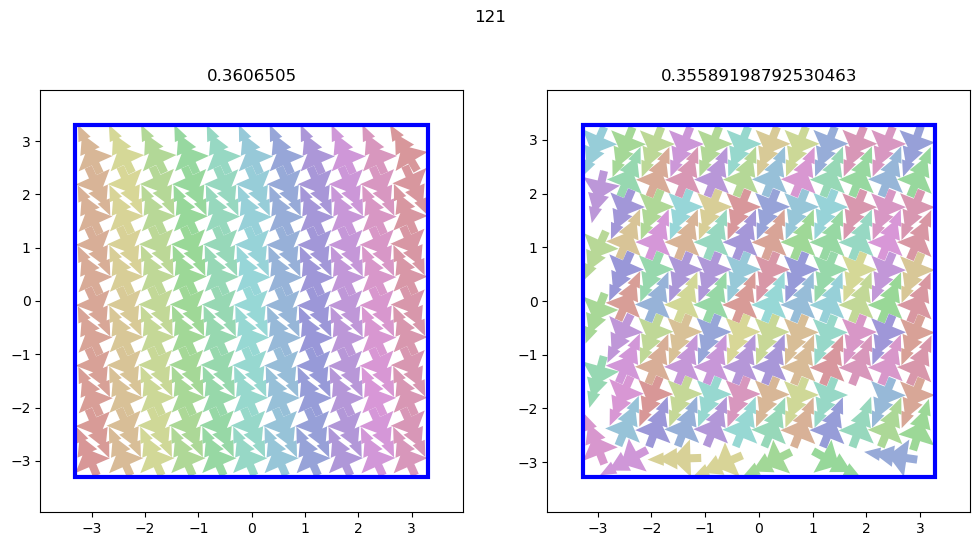

In [24]:
for N in [121]:
    _,ax = plt.subplots(1,2,figsize=(12,6))
    pack_vis_sol.pack_vis_sol(mine[0][N-1], solution_idx=0, ax=ax[0])
    plt.sca(ax[0])
    plt.title(mine[1][N-1])
    sol2 = copy.deepcopy(theirs[0][N-1])
    sol2.rotate(cp.array([np.pi/2]))
    sol2.snap()
    #sol2.xyt = cp.concatenate((overall_best[N-1].xyt, sol2.xyt), axis=1)
    pack_vis_sol.pack_vis_sol(sol2, solution_idx=0, ax=ax[1])
    plt.sca(ax[1])
    plt.title(theirs[1][N-1])
    plt.suptitle(N)

In [22]:
import pack_io
pd = pack_io.solution_list_to_dataframe(overall_best_legalized, compact=True)
pd.to_csv(kgs.temp_dir + 'submission.csv', index=False)

Score of generated dataframe: 72.19447456862262
